In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random
import time

In [2]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

In [3]:
N_STEPS = 50

LOOKUP_STEP = 1

SCALE = True
scale_str = f"scale-{int(SCALE)}"

SHUFFLE = True
shuffle_str = f"shuffle-{int(SHUFFLE)}"

SPLIT_BY_DATE = False
split_by_date_str = f"split_date-{int(SPLIT_BY_DATE)}"

TEST_SIZE = 0.2

FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]

date_now = time.strftime("%Y-%m-%d")

# model parameters

N_LAYERS = 3
CELL = LSTM
UNITS = 256
DROPOUT = 0.7
BIDIRECTIONAL = False

# training parameters

LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 800
epochs = f"epochs-{int(EPOCHS)}"

# Choose Ticker
ticker = "SPY"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-{epochs}"

* ticker (str/pd.DataFrame)
* n_steps (int) - default = 50
* scale (bool) - default = True
* shuffle (bool) - default = True
* lookup_step (int) - default = 1 (e.g next day)
* split_by_date (bool)
* test_size (float) - default = 0.2 
* feature_columns (list)

In [4]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

In [5]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)

    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # split dataset by date 
    if split_by_date:
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

    return result

In [6]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [7]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [8]:
def get_final_df(model, data):
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [9]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [10]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

In [11]:
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/800
90/90 [==============================] - 65s 672ms/step - loss: 0.0043 - mean_absolute_error: 0.0530 - val_loss: 8.5656e-05 - val_mean_absolute_error: 0.0100

Epoch 00001: val_loss improved from inf to 0.00009, saving model to results\2021-09-07_SPY-shuffle-1-scale-1-split_date-0-epochs-800.h5
Epoch 2/800
90/90 [==============================] - 61s 681ms/step - loss: 0.0012 - mean_absolute_error: 0.0306 - val_loss: 2.1244e-04 - val_mean_absolute_error: 0.0191

Epoch 00002: val_loss did not improve from 0.00009
Epoch 3/800
90/90 [==============================] - 50s 558ms/step - loss: 0.0010 - mean_absolute_error: 0.0282 - val_loss: 9.8582e-05 - val_mean_absolute_error: 0.0090

Epoch 00003: val_loss did not improve from 0.00009
Epoch 4/800
90/90 [==============================] - 54s 601ms/step - loss: 9.6950e-04 - mean_absolute_error: 0.0284 - val_loss: 1.5911e-04 - val_mean_absolute_error: 0.0130

Epoch 00004: val_loss did not improve from 0.00009
Epoch 5/800
90/90 [====

90/90 [==============================] - 40s 445ms/step - loss: 5.0794e-04 - mean_absolute_error: 0.0207 - val_loss: 1.4216e-04 - val_mean_absolute_error: 0.0120

Epoch 00035: val_loss did not improve from 0.00003
Epoch 36/800
90/90 [==============================] - 42s 463ms/step - loss: 4.2166e-04 - mean_absolute_error: 0.0187 - val_loss: 7.3477e-05 - val_mean_absolute_error: 0.0102

Epoch 00036: val_loss did not improve from 0.00003
Epoch 37/800
90/90 [==============================] - 44s 485ms/step - loss: 4.5102e-04 - mean_absolute_error: 0.0193 - val_loss: 7.6109e-05 - val_mean_absolute_error: 0.0085

Epoch 00037: val_loss did not improve from 0.00003
Epoch 38/800
90/90 [==============================] - 43s 473ms/step - loss: 3.9575e-04 - mean_absolute_error: 0.0183 - val_loss: 2.4611e-04 - val_mean_absolute_error: 0.0170

Epoch 00038: val_loss did not improve from 0.00003
Epoch 39/800
90/90 [==============================] - 39s 435ms/step - loss: 3.8402e-04 - mean_absolute_e

90/90 [==============================] - 41s 459ms/step - loss: 3.7414e-04 - mean_absolute_error: 0.0179 - val_loss: 2.9879e-05 - val_mean_absolute_error: 0.0059

Epoch 00070: val_loss did not improve from 0.00002
Epoch 71/800
90/90 [==============================] - 40s 449ms/step - loss: 3.9400e-04 - mean_absolute_error: 0.0191 - val_loss: 6.0844e-05 - val_mean_absolute_error: 0.0084

Epoch 00071: val_loss did not improve from 0.00002
Epoch 72/800
90/90 [==============================] - 40s 445ms/step - loss: 3.8059e-04 - mean_absolute_error: 0.0182 - val_loss: 5.5065e-05 - val_mean_absolute_error: 0.0083

Epoch 00072: val_loss did not improve from 0.00002
Epoch 73/800
90/90 [==============================] - 43s 478ms/step - loss: 3.7601e-04 - mean_absolute_error: 0.0182 - val_loss: 9.3600e-05 - val_mean_absolute_error: 0.0099

Epoch 00073: val_loss did not improve from 0.00002
Epoch 74/800
90/90 [==============================] - 42s 471ms/step - loss: 4.1741e-04 - mean_absolute_e

90/90 [==============================] - 45s 497ms/step - loss: 3.7433e-04 - mean_absolute_error: 0.0184 - val_loss: 2.8711e-05 - val_mean_absolute_error: 0.0056

Epoch 00105: val_loss did not improve from 0.00002
Epoch 106/800
90/90 [==============================] - 40s 441ms/step - loss: 3.9123e-04 - mean_absolute_error: 0.0183 - val_loss: 2.5176e-05 - val_mean_absolute_error: 0.0053

Epoch 00106: val_loss did not improve from 0.00002
Epoch 107/800
90/90 [==============================] - 39s 431ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0175 - val_loss: 1.2164e-04 - val_mean_absolute_error: 0.0145

Epoch 00107: val_loss did not improve from 0.00002
Epoch 108/800
90/90 [==============================] - 38s 426ms/step - loss: 3.6710e-04 - mean_absolute_error: 0.0179 - val_loss: 3.7897e-05 - val_mean_absolute_error: 0.0066

Epoch 00108: val_loss did not improve from 0.00002
Epoch 109/800
90/90 [==============================] - 39s 431ms/step - loss: 3.4681e-04 - mean_absolu


Epoch 00140: val_loss did not improve from 0.00002
Epoch 141/800
90/90 [==============================] - 37s 415ms/step - loss: 3.6123e-04 - mean_absolute_error: 0.0179 - val_loss: 4.6168e-05 - val_mean_absolute_error: 0.0059

Epoch 00141: val_loss did not improve from 0.00002
Epoch 142/800
90/90 [==============================] - 38s 419ms/step - loss: 3.1700e-04 - mean_absolute_error: 0.0166 - val_loss: 2.8102e-05 - val_mean_absolute_error: 0.0055

Epoch 00142: val_loss did not improve from 0.00002
Epoch 143/800
90/90 [==============================] - 38s 419ms/step - loss: 3.5613e-04 - mean_absolute_error: 0.0179 - val_loss: 3.0184e-05 - val_mean_absolute_error: 0.0059

Epoch 00143: val_loss did not improve from 0.00002
Epoch 144/800
90/90 [==============================] - 39s 429ms/step - loss: 3.4742e-04 - mean_absolute_error: 0.0175 - val_loss: 3.3712e-05 - val_mean_absolute_error: 0.0058

Epoch 00144: val_loss did not improve from 0.00002
Epoch 145/800
90/90 [===============

90/90 [==============================] - 38s 417ms/step - loss: 2.9206e-04 - mean_absolute_error: 0.0162 - val_loss: 2.2843e-05 - val_mean_absolute_error: 0.0044

Epoch 00176: val_loss did not improve from 0.00002
Epoch 177/800
90/90 [==============================] - 39s 434ms/step - loss: 3.0668e-04 - mean_absolute_error: 0.0160 - val_loss: 4.5752e-05 - val_mean_absolute_error: 0.0060

Epoch 00177: val_loss did not improve from 0.00002
Epoch 178/800
90/90 [==============================] - 38s 418ms/step - loss: 2.9139e-04 - mean_absolute_error: 0.0158 - val_loss: 5.1546e-05 - val_mean_absolute_error: 0.0074

Epoch 00178: val_loss did not improve from 0.00002
Epoch 179/800
90/90 [==============================] - 39s 437ms/step - loss: 2.9484e-04 - mean_absolute_error: 0.0162 - val_loss: 4.9439e-05 - val_mean_absolute_error: 0.0068

Epoch 00179: val_loss did not improve from 0.00002
Epoch 180/800
90/90 [==============================] - 39s 433ms/step - loss: 3.0835e-04 - mean_absolu


Epoch 00211: val_loss did not improve from 0.00002
Epoch 212/800
90/90 [==============================] - 37s 416ms/step - loss: 3.0156e-04 - mean_absolute_error: 0.0161 - val_loss: 2.9474e-05 - val_mean_absolute_error: 0.0051

Epoch 00212: val_loss did not improve from 0.00002
Epoch 213/800
90/90 [==============================] - 36s 404ms/step - loss: 3.2841e-04 - mean_absolute_error: 0.0168 - val_loss: 2.7569e-05 - val_mean_absolute_error: 0.0043

Epoch 00213: val_loss did not improve from 0.00002
Epoch 214/800
90/90 [==============================] - 39s 433ms/step - loss: 3.2298e-04 - mean_absolute_error: 0.0167 - val_loss: 3.8429e-05 - val_mean_absolute_error: 0.0065

Epoch 00214: val_loss did not improve from 0.00002
Epoch 215/800
90/90 [==============================] - 37s 408ms/step - loss: 3.0734e-04 - mean_absolute_error: 0.0163 - val_loss: 5.5001e-05 - val_mean_absolute_error: 0.0071

Epoch 00215: val_loss did not improve from 0.00002
Epoch 216/800
90/90 [===============

90/90 [==============================] - 37s 417ms/step - loss: 2.9985e-04 - mean_absolute_error: 0.0159 - val_loss: 4.5105e-05 - val_mean_absolute_error: 0.0075

Epoch 00247: val_loss did not improve from 0.00002
Epoch 248/800
90/90 [==============================] - 38s 426ms/step - loss: 3.2944e-04 - mean_absolute_error: 0.0168 - val_loss: 3.7723e-05 - val_mean_absolute_error: 0.0058

Epoch 00248: val_loss did not improve from 0.00002
Epoch 249/800
90/90 [==============================] - 36s 403ms/step - loss: 3.2320e-04 - mean_absolute_error: 0.0165 - val_loss: 2.2605e-04 - val_mean_absolute_error: 0.0141

Epoch 00249: val_loss did not improve from 0.00002
Epoch 250/800
90/90 [==============================] - 38s 421ms/step - loss: 3.1048e-04 - mean_absolute_error: 0.0164 - val_loss: 2.3762e-05 - val_mean_absolute_error: 0.0052

Epoch 00250: val_loss did not improve from 0.00002
Epoch 251/800
90/90 [==============================] - 37s 409ms/step - loss: 2.9486e-04 - mean_absolu

90/90 [==============================] - 35s 394ms/step - loss: 2.9440e-04 - mean_absolute_error: 0.0161 - val_loss: 2.2478e-05 - val_mean_absolute_error: 0.0040

Epoch 00283: val_loss did not improve from 0.00002
Epoch 284/800
90/90 [==============================] - 38s 419ms/step - loss: 2.9185e-04 - mean_absolute_error: 0.0158 - val_loss: 5.9406e-05 - val_mean_absolute_error: 0.0098

Epoch 00284: val_loss did not improve from 0.00002
Epoch 285/800
90/90 [==============================] - 37s 412ms/step - loss: 3.1872e-04 - mean_absolute_error: 0.0165 - val_loss: 4.0130e-05 - val_mean_absolute_error: 0.0061

Epoch 00285: val_loss did not improve from 0.00002
Epoch 286/800
90/90 [==============================] - 38s 423ms/step - loss: 3.0572e-04 - mean_absolute_error: 0.0162 - val_loss: 4.7892e-05 - val_mean_absolute_error: 0.0071

Epoch 00286: val_loss did not improve from 0.00002
Epoch 287/800
90/90 [==============================] - 38s 425ms/step - loss: 3.0773e-04 - mean_absolu


Epoch 00318: val_loss did not improve from 0.00002
Epoch 319/800
90/90 [==============================] - 38s 424ms/step - loss: 2.7732e-04 - mean_absolute_error: 0.0153 - val_loss: 2.0014e-05 - val_mean_absolute_error: 0.0043

Epoch 00319: val_loss did not improve from 0.00002
Epoch 320/800
90/90 [==============================] - 38s 424ms/step - loss: 2.7917e-04 - mean_absolute_error: 0.0154 - val_loss: 3.5886e-05 - val_mean_absolute_error: 0.0068

Epoch 00320: val_loss did not improve from 0.00002
Epoch 321/800
90/90 [==============================] - 37s 408ms/step - loss: 2.7110e-04 - mean_absolute_error: 0.0153 - val_loss: 2.2491e-05 - val_mean_absolute_error: 0.0046

Epoch 00321: val_loss did not improve from 0.00002
Epoch 322/800
90/90 [==============================] - 35s 391ms/step - loss: 2.8135e-04 - mean_absolute_error: 0.0157 - val_loss: 1.9004e-05 - val_mean_absolute_error: 0.0042

Epoch 00322: val_loss did not improve from 0.00002
Epoch 323/800
90/90 [===============


Epoch 00354: val_loss did not improve from 0.00002
Epoch 355/800
90/90 [==============================] - 36s 401ms/step - loss: 2.7157e-04 - mean_absolute_error: 0.0152 - val_loss: 3.1269e-05 - val_mean_absolute_error: 0.0049

Epoch 00355: val_loss did not improve from 0.00002
Epoch 356/800
90/90 [==============================] - 37s 414ms/step - loss: 2.7911e-04 - mean_absolute_error: 0.0154 - val_loss: 5.4360e-05 - val_mean_absolute_error: 0.0079

Epoch 00356: val_loss did not improve from 0.00002
Epoch 357/800
90/90 [==============================] - 37s 411ms/step - loss: 2.7583e-04 - mean_absolute_error: 0.0156 - val_loss: 3.7530e-05 - val_mean_absolute_error: 0.0066

Epoch 00357: val_loss did not improve from 0.00002
Epoch 358/800
90/90 [==============================] - 38s 422ms/step - loss: 3.1156e-04 - mean_absolute_error: 0.0163 - val_loss: 4.7967e-05 - val_mean_absolute_error: 0.0056

Epoch 00358: val_loss did not improve from 0.00002
Epoch 359/800
90/90 [===============


Epoch 00390: val_loss did not improve from 0.00002
Epoch 391/800
90/90 [==============================] - 37s 415ms/step - loss: 2.5814e-04 - mean_absolute_error: 0.0150 - val_loss: 2.7558e-05 - val_mean_absolute_error: 0.0046

Epoch 00391: val_loss did not improve from 0.00002
Epoch 392/800
90/90 [==============================] - 38s 420ms/step - loss: 2.7700e-04 - mean_absolute_error: 0.0156 - val_loss: 2.2837e-05 - val_mean_absolute_error: 0.0046

Epoch 00392: val_loss did not improve from 0.00002
Epoch 393/800
90/90 [==============================] - 38s 418ms/step - loss: 3.0590e-04 - mean_absolute_error: 0.0162 - val_loss: 2.3939e-05 - val_mean_absolute_error: 0.0050

Epoch 00393: val_loss did not improve from 0.00002
Epoch 394/800
90/90 [==============================] - 37s 408ms/step - loss: 2.8103e-04 - mean_absolute_error: 0.0154 - val_loss: 6.5358e-05 - val_mean_absolute_error: 0.0086

Epoch 00394: val_loss did not improve from 0.00002
Epoch 395/800
90/90 [===============

90/90 [==============================] - 36s 401ms/step - loss: 2.7471e-04 - mean_absolute_error: 0.0152 - val_loss: 3.0678e-05 - val_mean_absolute_error: 0.0052

Epoch 00426: val_loss did not improve from 0.00002
Epoch 427/800
90/90 [==============================] - 39s 433ms/step - loss: 2.7788e-04 - mean_absolute_error: 0.0153 - val_loss: 2.6989e-05 - val_mean_absolute_error: 0.0043

Epoch 00427: val_loss did not improve from 0.00002
Epoch 428/800
90/90 [==============================] - 37s 410ms/step - loss: 2.8632e-04 - mean_absolute_error: 0.0157 - val_loss: 2.5242e-05 - val_mean_absolute_error: 0.0052

Epoch 00428: val_loss did not improve from 0.00002
Epoch 429/800
90/90 [==============================] - 39s 430ms/step - loss: 2.9082e-04 - mean_absolute_error: 0.0155 - val_loss: 1.8827e-05 - val_mean_absolute_error: 0.0040

Epoch 00429: val_loss did not improve from 0.00002
Epoch 430/800
90/90 [==============================] - 38s 418ms/step - loss: 2.7280e-04 - mean_absolu

90/90 [==============================] - 38s 423ms/step - loss: 2.6852e-04 - mean_absolute_error: 0.0151 - val_loss: 1.6268e-05 - val_mean_absolute_error: 0.0036

Epoch 00462: val_loss did not improve from 0.00002
Epoch 463/800
90/90 [==============================] - 38s 427ms/step - loss: 2.5544e-04 - mean_absolute_error: 0.0151 - val_loss: 7.9203e-05 - val_mean_absolute_error: 0.0087

Epoch 00463: val_loss did not improve from 0.00002
Epoch 464/800
90/90 [==============================] - 39s 434ms/step - loss: 2.7171e-04 - mean_absolute_error: 0.0153 - val_loss: 1.9996e-05 - val_mean_absolute_error: 0.0044

Epoch 00464: val_loss did not improve from 0.00002
Epoch 465/800
90/90 [==============================] - 38s 418ms/step - loss: 2.6813e-04 - mean_absolute_error: 0.0150 - val_loss: 3.1111e-05 - val_mean_absolute_error: 0.0057

Epoch 00465: val_loss did not improve from 0.00002
Epoch 466/800
90/90 [==============================] - 37s 412ms/step - loss: 2.5821e-04 - mean_absolu


Epoch 00497: val_loss did not improve from 0.00002
Epoch 498/800
90/90 [==============================] - 38s 422ms/step - loss: 2.6708e-04 - mean_absolute_error: 0.0150 - val_loss: 2.0166e-05 - val_mean_absolute_error: 0.0048

Epoch 00498: val_loss did not improve from 0.00002
Epoch 499/800
90/90 [==============================] - 36s 398ms/step - loss: 2.5869e-04 - mean_absolute_error: 0.0147 - val_loss: 2.6967e-05 - val_mean_absolute_error: 0.0054

Epoch 00499: val_loss did not improve from 0.00002
Epoch 500/800
90/90 [==============================] - 39s 430ms/step - loss: 2.6551e-04 - mean_absolute_error: 0.0150 - val_loss: 4.7132e-05 - val_mean_absolute_error: 0.0080

Epoch 00500: val_loss did not improve from 0.00002
Epoch 501/800
90/90 [==============================] - 37s 406ms/step - loss: 2.7393e-04 - mean_absolute_error: 0.0153 - val_loss: 3.7490e-05 - val_mean_absolute_error: 0.0067

Epoch 00501: val_loss did not improve from 0.00002
Epoch 502/800
90/90 [===============


Epoch 00533: val_loss did not improve from 0.00002
Epoch 534/800
90/90 [==============================] - 37s 417ms/step - loss: 2.6382e-04 - mean_absolute_error: 0.0151 - val_loss: 2.9772e-05 - val_mean_absolute_error: 0.0050

Epoch 00534: val_loss did not improve from 0.00002
Epoch 535/800
90/90 [==============================] - 38s 421ms/step - loss: 2.4673e-04 - mean_absolute_error: 0.0146 - val_loss: 2.0070e-05 - val_mean_absolute_error: 0.0046

Epoch 00535: val_loss did not improve from 0.00002
Epoch 536/800
90/90 [==============================] - 39s 430ms/step - loss: 2.6314e-04 - mean_absolute_error: 0.0149 - val_loss: 3.5968e-05 - val_mean_absolute_error: 0.0060

Epoch 00536: val_loss did not improve from 0.00002
Epoch 537/800
90/90 [==============================] - 36s 405ms/step - loss: 2.6212e-04 - mean_absolute_error: 0.0147 - val_loss: 4.1605e-05 - val_mean_absolute_error: 0.0052

Epoch 00537: val_loss did not improve from 0.00002
Epoch 538/800
90/90 [===============

90/90 [==============================] - 35s 391ms/step - loss: 2.4882e-04 - mean_absolute_error: 0.0148 - val_loss: 5.4997e-05 - val_mean_absolute_error: 0.0081

Epoch 00569: val_loss did not improve from 0.00001
Epoch 570/800
90/90 [==============================] - 37s 408ms/step - loss: 2.7752e-04 - mean_absolute_error: 0.0151 - val_loss: 3.7548e-05 - val_mean_absolute_error: 0.0073

Epoch 00570: val_loss did not improve from 0.00001
Epoch 571/800
90/90 [==============================] - 37s 414ms/step - loss: 2.4910e-04 - mean_absolute_error: 0.0144 - val_loss: 1.9271e-05 - val_mean_absolute_error: 0.0043

Epoch 00571: val_loss did not improve from 0.00001
Epoch 572/800
90/90 [==============================] - 38s 423ms/step - loss: 2.4819e-04 - mean_absolute_error: 0.0145 - val_loss: 7.0220e-05 - val_mean_absolute_error: 0.0070

Epoch 00572: val_loss did not improve from 0.00001
Epoch 573/800
90/90 [==============================] - 38s 425ms/step - loss: 2.4500e-04 - mean_absolu

90/90 [==============================] - 37s 412ms/step - loss: 2.3963e-04 - mean_absolute_error: 0.0143 - val_loss: 2.7893e-05 - val_mean_absolute_error: 0.0054

Epoch 00605: val_loss did not improve from 0.00001
Epoch 606/800
90/90 [==============================] - 36s 406ms/step - loss: 2.5286e-04 - mean_absolute_error: 0.0148 - val_loss: 2.1948e-05 - val_mean_absolute_error: 0.0047

Epoch 00606: val_loss did not improve from 0.00001
Epoch 607/800
90/90 [==============================] - 38s 424ms/step - loss: 2.4607e-04 - mean_absolute_error: 0.0147 - val_loss: 2.3703e-05 - val_mean_absolute_error: 0.0040

Epoch 00607: val_loss did not improve from 0.00001
Epoch 608/800
90/90 [==============================] - 37s 413ms/step - loss: 2.5949e-04 - mean_absolute_error: 0.0147 - val_loss: 1.7516e-05 - val_mean_absolute_error: 0.0043

Epoch 00608: val_loss did not improve from 0.00001
Epoch 609/800
90/90 [==============================] - 37s 407ms/step - loss: 2.6049e-04 - mean_absolu


Epoch 00640: val_loss did not improve from 0.00001
Epoch 641/800
90/90 [==============================] - 36s 396ms/step - loss: 2.4305e-04 - mean_absolute_error: 0.0147 - val_loss: 3.3877e-05 - val_mean_absolute_error: 0.0064

Epoch 00641: val_loss did not improve from 0.00001
Epoch 642/800
90/90 [==============================] - 38s 423ms/step - loss: 2.4809e-04 - mean_absolute_error: 0.0146 - val_loss: 4.8941e-05 - val_mean_absolute_error: 0.0083

Epoch 00642: val_loss did not improve from 0.00001
Epoch 643/800
90/90 [==============================] - 37s 413ms/step - loss: 2.7118e-04 - mean_absolute_error: 0.0150 - val_loss: 2.7354e-05 - val_mean_absolute_error: 0.0055

Epoch 00643: val_loss did not improve from 0.00001
Epoch 644/800
90/90 [==============================] - 38s 427ms/step - loss: 2.5773e-04 - mean_absolute_error: 0.0148 - val_loss: 2.0339e-05 - val_mean_absolute_error: 0.0045

Epoch 00644: val_loss did not improve from 0.00001
Epoch 645/800
90/90 [===============


Epoch 00676: val_loss did not improve from 0.00001
Epoch 677/800
90/90 [==============================] - 38s 417ms/step - loss: 2.4343e-04 - mean_absolute_error: 0.0144 - val_loss: 1.1052e-04 - val_mean_absolute_error: 0.0106

Epoch 00677: val_loss did not improve from 0.00001
Epoch 678/800
90/90 [==============================] - 39s 432ms/step - loss: 2.5035e-04 - mean_absolute_error: 0.0146 - val_loss: 1.9429e-05 - val_mean_absolute_error: 0.0041

Epoch 00678: val_loss did not improve from 0.00001
Epoch 679/800
90/90 [==============================] - 37s 410ms/step - loss: 2.5163e-04 - mean_absolute_error: 0.0147 - val_loss: 5.1630e-05 - val_mean_absolute_error: 0.0074

Epoch 00679: val_loss did not improve from 0.00001
Epoch 680/800
90/90 [==============================] - 36s 395ms/step - loss: 2.3887e-04 - mean_absolute_error: 0.0144 - val_loss: 1.8774e-05 - val_mean_absolute_error: 0.0044

Epoch 00680: val_loss did not improve from 0.00001
Epoch 681/800
90/90 [===============


Epoch 00712: val_loss did not improve from 0.00001
Epoch 713/800
90/90 [==============================] - 39s 436ms/step - loss: 2.3120e-04 - mean_absolute_error: 0.0144 - val_loss: 3.0569e-05 - val_mean_absolute_error: 0.0054

Epoch 00713: val_loss did not improve from 0.00001
Epoch 714/800
90/90 [==============================] - 38s 428ms/step - loss: 2.6634e-04 - mean_absolute_error: 0.0146 - val_loss: 2.5921e-05 - val_mean_absolute_error: 0.0057

Epoch 00714: val_loss did not improve from 0.00001
Epoch 715/800
90/90 [==============================] - 38s 427ms/step - loss: 2.3986e-04 - mean_absolute_error: 0.0142 - val_loss: 1.7566e-05 - val_mean_absolute_error: 0.0038

Epoch 00715: val_loss did not improve from 0.00001
Epoch 716/800
90/90 [==============================] - 38s 422ms/step - loss: 2.3546e-04 - mean_absolute_error: 0.0143 - val_loss: 2.7434e-05 - val_mean_absolute_error: 0.0045

Epoch 00716: val_loss did not improve from 0.00001
Epoch 717/800
90/90 [===============

90/90 [==============================] - 44s 491ms/step - loss: 2.5646e-04 - mean_absolute_error: 0.0144 - val_loss: 3.1374e-05 - val_mean_absolute_error: 0.0052

Epoch 00748: val_loss did not improve from 0.00001
Epoch 749/800
90/90 [==============================] - 41s 461ms/step - loss: 2.5722e-04 - mean_absolute_error: 0.0146 - val_loss: 3.9233e-05 - val_mean_absolute_error: 0.0058

Epoch 00749: val_loss did not improve from 0.00001
Epoch 750/800
90/90 [==============================] - 46s 511ms/step - loss: 2.5039e-04 - mean_absolute_error: 0.0148 - val_loss: 4.2228e-05 - val_mean_absolute_error: 0.0064

Epoch 00750: val_loss did not improve from 0.00001
Epoch 751/800
90/90 [==============================] - 50s 552ms/step - loss: 2.2997e-04 - mean_absolute_error: 0.0140 - val_loss: 2.9604e-05 - val_mean_absolute_error: 0.0055

Epoch 00751: val_loss did not improve from 0.00001
Epoch 752/800
90/90 [==============================] - 48s 537ms/step - loss: 2.8688e-04 - mean_absolu

90/90 [==============================] - 48s 531ms/step - loss: 2.5312e-04 - mean_absolute_error: 0.0146 - val_loss: 1.8463e-05 - val_mean_absolute_error: 0.0039

Epoch 00784: val_loss did not improve from 0.00001
Epoch 785/800
90/90 [==============================] - 47s 520ms/step - loss: 2.5224e-04 - mean_absolute_error: 0.0145 - val_loss: 5.5789e-05 - val_mean_absolute_error: 0.0065

Epoch 00785: val_loss did not improve from 0.00001
Epoch 786/800
90/90 [==============================] - 48s 533ms/step - loss: 2.4028e-04 - mean_absolute_error: 0.0139 - val_loss: 1.7760e-05 - val_mean_absolute_error: 0.0042

Epoch 00786: val_loss did not improve from 0.00001
Epoch 787/800
90/90 [==============================] - 49s 546ms/step - loss: 2.4641e-04 - mean_absolute_error: 0.0145 - val_loss: 4.3646e-05 - val_mean_absolute_error: 0.0056

Epoch 00787: val_loss did not improve from 0.00001
Epoch 788/800
90/90 [==============================] - 48s 534ms/step - loss: 2.5416e-04 - mean_absolu

In [12]:
"""
FROM NEWEST RUN
"""

# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [13]:
"""
FROM PREVIOUS RUNS

name = '2021-09-06_AMZN-shuffle-1-scale-1-split_date-0-epochs-500'

# load optimal model weights from results folder
model_path = os.path.join("results", name) + ".h5"
model.load_weights(model_path)

"""

'\nFROM PREVIOUS RUNS\n\nname = \'2021-09-06_AMZN-shuffle-1-scale-1-split_date-0-epochs-500\'\n\n# load optimal model weights from results folder\nmodel_path = os.path.join("results", name) + ".h5"\nmodel.load_weights(model_path)\n\n'

In [14]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [23]:
display(mae)

0.003155990969389677

In [15]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [16]:
# predict the future price
future_price = predict(model, data)

In [17]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [18]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 1 days is 441.70$
huber_loss loss: 1.2843770491599571e-05
Mean Absolute Error: 26.837655306014874
Accuracy score: 0.5324947589098532
Total buy profit: 154.60021400451652
Total sell profit: -40.48010826110847
Total profit: 114.12010574340805
Profit per trade: 0.07974850156772051


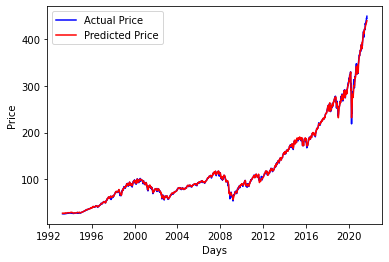

In [19]:
# plot true/pred prices graph
plot_graph(final_df)

In [20]:
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

In [22]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

trace1 = go.Scatter(
    y=history.history['loss'],
    name = "Training Loss",
    marker=dict(color='rgba(171, 50, 96, 0.6)'))
trace2 = go.Scatter(
    y=history.history['val_loss'],
    name = "Validation Loss",
    marker=dict(color='rgba(12, 50, 196, 0.6)'))

data = [trace1, trace2]
layout = go.Layout(title='Loss and Val_Loss in 500 Epochs',
                   xaxis=dict(title='Epoch'),
                   yaxis=dict(title='Loss'),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, config={'showLink': True})

In [27]:
%load_ext tensorboard
%tensorboard --logdir="logs"

Reusing TensorBoard on port 6006 (pid 31368), started 0:00:52 ago. (Use '!kill 31368' to kill it.)